In [76]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 读取图像并转换为浮点型
image = cv2.imread('brushes/brush_fromweb2_large_vertical.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)



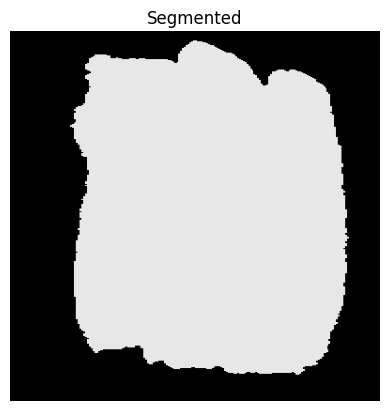

In [77]:
# 定义 K-means 聚类参数
k = 2  # 聚类数，可以根据图像复杂度调整
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# 将聚类结果转换为图像
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image.shape)

# 显示结果
plt.imshow(segmented_image, cmap='gray')
plt.title('Segmented')
plt.axis('off')
plt.show()


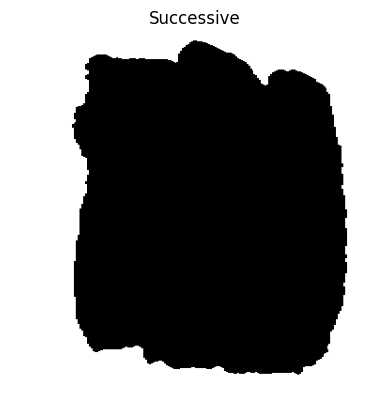

In [78]:
# 灰度化图像
gray_segmented = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)

# 二值化图像
_, binary_segmented = cv2.threshold(gray_segmented, 128, 255, cv2.THRESH_BINARY_INV)

# 使用形态学操作填充区域，使得每个聚类形成连续区域
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
closed = cv2.morphologyEx(binary_segmented, cv2.MORPH_CLOSE, kernel)
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

# 显示结果
plt.imshow(opened, cmap='gray')
plt.title('Successive')
plt.axis('off')
plt.show()


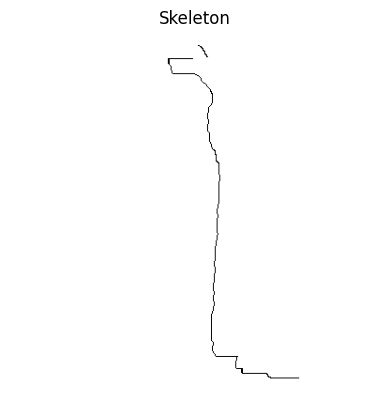

In [84]:
# 计算各行中间点连成的线
rows, cols = opened.shape
row_mid_points = []
for row in range(rows):
    col_indices = np.where(opened[row, :] == 0)[0]
    if len(col_indices) > 0:
        mid_col = (col_indices[0] + col_indices[-1]) // 2
        row_mid_points.append((mid_col, row))

# 计算各列中间点连成的线
col_mid_points = []
for col in range(cols):
    row_indices = np.where(opened[:, col] == 0)[0]
    if len(row_indices) > 0:
        mid_row = (row_indices[0] + row_indices[-1]) // 2
        col_mid_points.append((col, mid_row))

# 取较长的一条作为中轴线
if len(row_mid_points) > len(col_mid_points):
    mid_points = row_mid_points
    mid_type = 'ver'
else:
    mid_points = col_mid_points
    mid_type = 'hor'

# 将中轴线绘制到图像上
skeleton = np.ones_like(opened)*255

# 使用插值填补不连续的部分
if len(mid_points) > 1:
    x = np.array([p[0] for p in mid_points])
    y = np.array([p[1] for p in mid_points])

    if mid_type == 'ver':
        # 行插值
        f = interp1d(y, x, kind='linear', fill_value='extrapolate')
        y = np.linspace(y.min(), y.max(), num=100*rows)
        x = f(y).astype(np.int32)
        # 列插值
        f = interp1d(x, y, kind='nearest', fill_value='extrapolate')
        x = np.linspace(x.min(), x.max(), num=100*cols)
        y = f(x).astype(np.int32)
    else:
        # 列插值
        f = interp1d(x, y, kind='linear', fill_value='extrapolate')
        x = np.linspace(x.min(), x.max(), num=100*cols)
        y = f(x).astype(np.int32)
        # 行插值
        f = interp1d(y, x, kind='nearest', fill_value='extrapolate')
        y = np.linspace(y.min(), y.max(), num=100*rows)
        x = f(y).astype(np.int32)

    interpolated_points = np.vstack((x, y)).T
else:
    interpolated_points = mid_points

for point in interpolated_points:
    if 0 <= point[0] < cols and 0 <= point[1] < rows:
        skeleton[int(point[1]), int(point[0])] = 0  # 黑色中轴线

for point in mid_points:
    skeleton[point[1], point[0]] = 0

# 应用形态学操作去除孤立点
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
skeleton = cv2.morphologyEx(skeleton, cv2.MORPH_OPEN, kernel, iterations=5)


plt.imshow(skeleton, cmap='gray')
plt.title('Skeleton')
plt.axis('off')
plt.show()